# Assignment III: Clustering and Classification of MEP's Tweets

---

>Konstantinos Kyrkos <br>
>Registration Number p3351907 <br>
>kkyrkos@aueb.gr

This notebook provides my solutions for the third assignment for the Practical Data Science class at Data Science MSc at AUEB. <br>
Bollow you will find the solution to all 3 parts of the assignment. <br>
The only prerequisites for running the commands below are providing the retweets.csv file found in the following link and a config file named "twitter_config.py" which is used in order to connect and use the Twitter Api.
https://www.clarin.si/repository/xmlui/handle/11356/1071#

## Data Preparation


We start by importing the libraries we will use in the following exercises.

In [2]:
import pandas as pd
import numpy as np
import tweepy
import json
from twitter_config import config
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn import metrics
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, silhouette_score, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from scipy.stats import sem
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from scipy.stats import sem
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from yellowbrick.cluster import InterclusterDistance
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
import xgboost as xgb

Next, we import the file we will use to extract the retweets and then we filter the data imported to keep only the tweets written in English.

In [3]:
data = pd.read_csv("retweets.csv") 
data.head()

data = data.loc[data['lang'] == 'en']


We will use describe method to have an overview of the data we have to manage.

In [4]:
print(data.describe())

         origUserId      origMepId  origMepGroupId  origMepCountryId  \
count  1.379600e+04   13796.000000    13796.000000      13796.000000   
mean   4.823502e+08   73536.347202        3.516527         20.398884   
std    7.144207e+08   50570.469713        1.997484          8.856113   
min    9.234892e+06     840.000000        0.000000          0.000000   
25%    1.976367e+07    4555.000000        1.000000         13.000000   
50%    1.444836e+08   96907.000000        4.000000         27.000000   
75%    8.198434e+08  124940.000000        6.000000         27.000000   
max    3.520822e+09  130833.000000        8.000000         27.000000   

       retweetUserId   retweetMepId  retweetMepGroupId  retweetMepCountryId  \
count   1.379600e+04   13796.000000       13796.000000          13796.00000   
mean    6.329301e+08   99903.399681           3.536750             20.63185   
std     8.118056e+08   40182.608699           2.035608              8.60228   
min     9.234892e+06     840.000000

Next we set the parameters needed in order to access the tweeter api.

In [5]:
auth = tweepy.OAuthHandler(config['consumer_key'], config['consumer_secret'])
auth.set_access_token(config['access_token'], config['access_token_secret'])

api = tweepy.API(auth)

At this point we can access the tweeter api using the call statuses_lookup and feeding it with 100 tweet ids per time. 

In [6]:
tweet_set = []
entries = len(data.origTweetId)
tweet_IDs = data.origTweetId

try:
    for i in range((entries // 100) + 1):
        end_loc = min((i + 1) * 100, entries)
        tweet_cds = tweet_IDs.iloc[i * 100:end_loc].tolist()
        tweets = api.statuses_lookup(id_=tweet_cds)
        tweet_set.append(tweets)
    
except tweepy.TweepError:
    print ('Something went wrong, quitting...')


Next, we want to remove the empty tweets from the ones we got and store them in a more usefull manner. After that we print one tweet to see its format.

In [7]:
n_tweets = tweet_set
filtered_tweets = []

for tweet_group in n_tweets: 
    for tweet in tweet_group:
        if not (tweet._json['text'].isspace()):
            filtered_tweets.append(tweet._json)
        
print(filtered_tweets[0])


{'created_at': 'Mon Oct 06 09:05:14 +0000 2014', 'id': 519050739642286080, 'id_str': '519050739642286080', 'text': "Lord Hill's written answers to EP are now on my blog. No transparency on his lobbying past. Shame! http://t.co/OT7TGKGDek #EPhearings2014", 'truncated': False, 'entities': {'hashtags': [{'text': 'EPhearings2014', 'indices': [122, 137]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'http://t.co/OT7TGKGDek', 'expanded_url': 'http://www.sven-giegold.de/2014/antworten-der-kommissionskandidatinnen', 'display_url': 'sven-giegold.de/2014/antworten…', 'indices': [99, 121]}]}, 'source': '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 16705726, 'id_str': '16705726', 'name': 'Sven Giegold', 'screen_name': 'sven_giegold', 'location': 'Düsseldorf', 'description': 'Spitzenkandidat v

Now we will put the tweets we found to a new column in a new copy of our original dataframe in order to keep the original for any later use. Then we will print the first 5 rows of the new dataframe in order to confirm that the new column has been added correctly.

In [8]:
data_n = data

data_n['Tweet'] = ''

for tweet in filtered_tweets:
    data_n.loc[data_n['origTweetId'] == tweet['id'], ['Tweet']] = tweet['text']

print(data_n.head())

    origUserId origUserScreenName  origMepId    origMepName  origMepGroupId  \
3     19017675       Nigel_Farage       4525   Nigel FARAGE               6   
5     17675072       MartinSchulz       1911  Martin SCHULZ               1   
11    17675072       MartinSchulz       1911  Martin SCHULZ               1   
12   744743599           Tim_Aker      99650       Tim AKER               6   
13   744743599           Tim_Aker      99650       Tim AKER               6   

   origMepGroupShort  origMepCountryId origMepCountryShort  retweetUserId  \
3               EFDD                27                 GBR      121171051   
5                S&D                10                 DEU     1668992125   
11               S&D                10                 DEU       21648649   
12              EFDD                27                 GBR      121171051   
13              EFDD                27                 GBR       19017675   

   retweetUserScreenName  ...  retweetMepGroupId retweetMepGro

After noticing that some of the Tweets contain a url which clearly means nothing for our model we can simply remove it using a regular expression.

In [9]:
import re
def removeUrl(inputTweet):
    return re.sub(r"http\S+", "", inputTweet, flags=re.MULTILINE)

data_n['Tweet'] = data_n['Tweet'].apply(lambda x: removeUrl(x))

Next, in order to clear our dataframe, we will remove the rows which have empty tweet text and we will print the length of it before and after the process in order to see whether our work have given any results.

In [10]:
n_data_n = data_n
print(len(n_data_n))
n_data_n['Tweet'].replace('', np.nan, inplace=True)
n_data_n.dropna(subset=['Tweet'], inplace=True)
print(len(n_data_n))


13796
12932


Our next move is to group our results by the group of the MEP that posted each tweet.

In [11]:
grouped = n_data_n.groupby('origMepGroupShort')

print(grouped)

Then we remove the groups which have less than 50 tweets and print the new length of the dataframe to see whether this process has made any difference in our dataset.

In [12]:
final = grouped.filter(lambda x: len(x) > 50)
print(len(final))

12908


## Clustering

For this part of the exercise, we want cluster the tweets based on their text using k-means.

We start by using the count vectorizer provided from sklearn.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

Now using the CountVectorizer from above we will create a bag of words which we will use next for k-means. We convert everything to lowercase, use min_df=10, max_df=0.5 and remove all English stopwords.

In [14]:
tf_vectorizer = CountVectorizer(strip_accents='unicode',
                                lowercase=True,
                                max_df=0.5, 
                                min_df=10,
                                stop_words='english')

X = tf_vectorizer.fit_transform(final['Tweet']).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Next, we use the elbow method, to investigate the best number of clusters for our data.

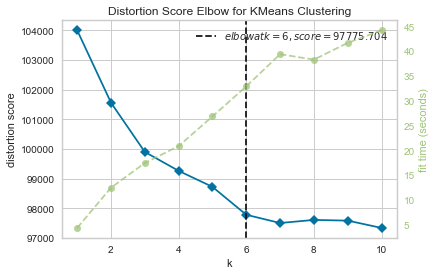

In [66]:
kmeans = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(1,11))

visualizer.fit(X)
visualizer.show()

The elbow method suggests using 6 clusters for our data but to be sure and validate this result we  can try the silhouette method in order to verify the results we got and settle on how many clusters we will use.

For n_clusters = 2 The average silhouette_score is : 0.04911702862067595
For n_clusters = 3 The average silhouette_score is : 0.04354153449388772
For n_clusters = 4 The average silhouette_score is : 0.030265907840674428
For n_clusters = 5 The average silhouette_score is : 0.030936327139231758
For n_clusters = 6 The average silhouette_score is : 0.029887949595709465
For n_clusters = 7 The average silhouette_score is : 0.021122910411837212
For n_clusters = 8 The average silhouette_score is : 0.012934751461754435
For n_clusters = 9 The average silhouette_score is : 0.013130592294198872


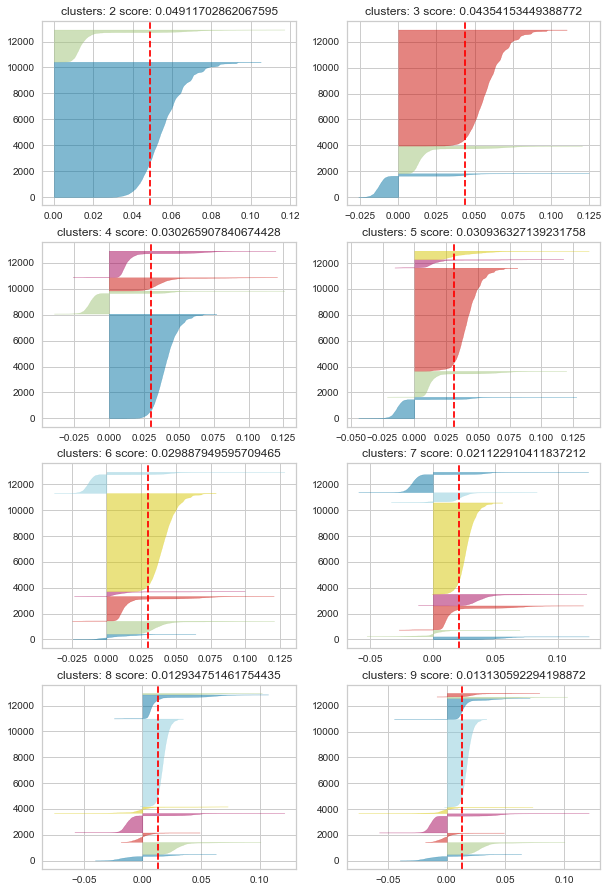

In [15]:

plt.figure(figsize=(2 * 5,  10 * 4))
silhouette_scores = []
scores = {}
for n_clusters in range(2, 10):
    plt.subplot(10, 2, n_clusters - 1)
    kmeans = KMeans(n_clusters, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(X)
    scores[n_clusters] = visualizer.silhouette_score_
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

Here we can see that silhouette method suggests using 2 clusters, but elbow method suggested 6 so we have to try another approach in order to decide the cluster number. In order to decide we will use the silhouette method scores in order to plot the along with their respected cluster sizes. 

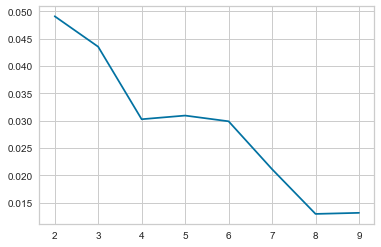

In [19]:
size = range(2, 10)
plt.plot(size, silhouette_scores)

Here we can see that the score of the method keeps droping until the point of 4 and 6 clusters. These are the points where we could draw a vertical line indicating that this would be the point we would stop searching for the best cluster number. Since elbow method too suggested using 6 cluster we will try spliting our data into 6 clusters.

Now we will visualize the clusters using Yellowbrick's InterclusterDistance in order to have a clear view of how the data are clustered.

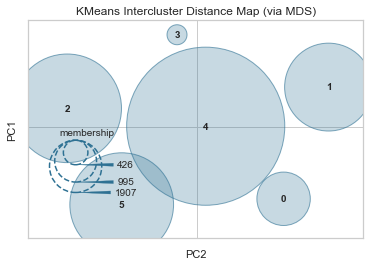

In [24]:
model = KMeans(6, random_state=42)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        
visualizer.show() 

From the last plot we can see that our model does a good job clustering these tweets into 6 clusters, creating only on mediocre conflict between clusters 4 and 5. Next we can print the centers of our clusters.

In [25]:
centers = model.cluster_centers_
print(centers)

[[-8.67361738e-18  4.69483568e-03  7.04225352e-03 ...  6.72205347e-18
  -1.19262239e-18  7.04225352e-03]
 [-2.60208521e-18  1.70854271e-02  2.01005025e-03 ... -1.92987987e-17
  -1.07336015e-17  1.00502513e-03]
 [ 2.09753540e-03  1.20608285e-02  6.29260619e-03 ...  1.57315155e-03
   1.04876770e-03  2.09753540e-03]
 [ 8.47457627e-03  5.64971751e-03  1.12994350e-02 ...  6.07153217e-18
   2.27682456e-18  5.85469173e-18]
 [ 2.89855072e-03  1.04084321e-02  5.66534914e-03 ...  1.05401845e-03
   7.90513834e-04  1.71277997e-03]
 [ 1.83374083e-03  4.88997555e-03  4.88997555e-03 ...  1.22249389e-03
   1.22249389e-03  1.22249389e-03]]


In order to find the top 30 features per cluster we have to find for each cluster centroid, which token vectors have the largest projection onto that centroid and then find the corresponding terms.

In [26]:
features = tf_vectorizer.get_feature_names()
relevant_labels = list(set(model.labels_))
centroids = model.cluster_centers_.argsort()[:,::-1]
for this_label in relevant_labels:
    print('Cluster {}:'.format(this_label), end='')
    for ind in centroids[this_label, :30]:
        print(' {}'.format(features[ind]), end='')
    print('')
    print('------------------------------------------------------------------------------------')

Cluster 0: meps labour eu amp today vote uk eurolabour support ttip action tory parliament meeting calling join voted energy steel help just work say saveoursteel ukip lnbdublin food cameron theprogressives debate
------------------------------------------------------------------------------------
Cluster 1: ukip vote labour today party nhs people amp eu uk poll just election policy lab immigration voters tories mep national support farage campaign britain great want tory new real voting
------------------------------------------------------------------------------------
Cluster 2: eu uk leave cameron referendum people britain today need european membership want just migration europe trade eppgroup turkey support vote policy borders says right member control campaign states immigration labour
------------------------------------------------------------------------------------
Cluster 3: debate eu amp ttip today vote european live parliament ep europarl_en digital votes plenary looking 

The words make sense because they are all possible and common words a member of a european political party would use. But with a quick look one could not really tell which cluster represents which party or another possible way in which the tweets could have been clustered.

## Classification

For the purpose of this exercise we want to train at least two algorithms to learn to classify an unseen tweet. The target variable should be the political party of the original poster and the training features should be the original tweet's text.

We start by spliting our data into a training set and a testing set. We choose to keep the 80% of our data for training our model and 20% of them for testing it. We also transform our categorical variable which described the political party in which the member of the parliament who made the Tweet belongs to a numerical one in order to use it next in our algorithms.

In [15]:
X = tf_vectorizer.fit_transform(final['Tweet']).toarray()
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

final.origMepGroupShort = pd.Categorical(final.origMepGroupShort)
y = final["origMepGroupShort"].cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Now we will try various different algorithms for validating our data. We will use in each case cross validation in order to find the best parameters for the best algorithm for our case. <br>
The first thing we will try is decision trees and more specifically random forest classification and extremely randomized trees in order to find how well the could fit our data.

In [33]:
classifier = RandomForestClassifier(n_estimators=100, random_state=0)
classifier.fit(X_train, y_train) 
tree_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, tree_pred))
print(classification_report(y_test, tree_pred))
print(accuracy_score(y_test, tree_pred)) 

[[206   8  35  43   1  16  54]
 [ 21 102  63  10   1   3  46]
 [ 16   5 545   5   0  10  39]
 [ 26   5  14 315   0  12  58]
 [  6   2   1   3  34   2  20]
 [ 27   4  20  15   0 113  46]
 [ 39   6  87  27   0  10 461]]
              precision    recall  f1-score   support

           0       0.60      0.57      0.59       363
           1       0.77      0.41      0.54       246
           2       0.71      0.88      0.79       620
           3       0.75      0.73      0.74       430
           4       0.94      0.50      0.65        68
           5       0.68      0.50      0.58       225
           6       0.64      0.73      0.68       630

    accuracy                           0.69      2582
   macro avg       0.73      0.62      0.65      2582
weighted avg       0.69      0.69      0.68      2582

0.6878388845855926


With accuracy of 0.687 we have found surely a good approch with our first try, but since this approach was the first, we really don't know how well we 've done, so it's important to keep trying other approaches.

In [16]:
extremely_rts = ExtraTreesClassifier(n_estimators=50, 
                                     max_depth=None,
                                     min_samples_split=2, 
                                     random_state=42)

scores = cross_val_score(extremely_rts, X_train, y_train, cv=5)
extremely_rts.fit(X_train, y_train)
extra_tree_pred = extremely_rts.predict(X_test)

print(confusion_matrix(y_test, extra_tree_pred))
print(classification_report(y_test, extra_tree_pred))
print(accuracy_score(y_test, extra_tree_pred)) 

[[219   6  33  45   3  14  43]
 [ 18 109  64  13   0   4  38]
 [ 18   6 551   5   0  12  28]
 [ 23   6  13 322   1  14  51]
 [  3   1   5   5  36   2  16]
 [ 28   3  22  18   1 115  38]
 [ 35   7  75  34   0  17 462]]
              precision    recall  f1-score   support

           0       0.64      0.60      0.62       363
           1       0.79      0.44      0.57       246
           2       0.72      0.89      0.80       620
           3       0.73      0.75      0.74       430
           4       0.88      0.53      0.66        68
           5       0.65      0.51      0.57       225
           6       0.68      0.73      0.71       630

    accuracy                           0.70      2582
   macro avg       0.73      0.64      0.67      2582
weighted avg       0.71      0.70      0.70      2582

0.7025561580170411


This time with extra trees classifier we have done even better with average score of 0.702! We keep trying other approaches in order to find the one which fits in our data best.

In [35]:
text_clf = Pipeline([
                     ('clf', MultinomialNB())
                    ])

text_clf.fit(X_train, y_train)
multinom_pred = text_clf.predict(X_test)
print(confusion_matrix(y_test, multinom_pred))
print(classification_report(y_test, multinom_pred))
print(accuracy_score(y_test, multinom_pred)) 

[[189   0  53  52   1  12  56]
 [ 18  50 109  21   0   0  48]
 [  6   0 563  11   0   2  38]
 [ 29   2  24 302   0  10  63]
 [  7   0  14   5  18   2  22]
 [ 28   1  44  30   0  75  47]
 [ 37   2  79  30   0   8 474]]
              precision    recall  f1-score   support

           0       0.60      0.52      0.56       363
           1       0.91      0.20      0.33       246
           2       0.64      0.91      0.75       620
           3       0.67      0.70      0.69       430
           4       0.95      0.26      0.41        68
           5       0.69      0.33      0.45       225
           6       0.63      0.75      0.69       630

    accuracy                           0.65      2582
   macro avg       0.73      0.53      0.55      2582
weighted avg       0.67      0.65      0.62      2582

0.6471727343144849


The multinomial distribution gave a score of 0.647 but we have to set a barrier in order to know how good that was. Stil not better than ExtraTreesClassifier.

In [36]:
gauss = GaussianNB()
scores = cross_val_score(gauss, X_train, y_train, cv=5)
gauss.fit(X_train, y_train)
gaus_pred = gauss.predict(X_test)
print(confusion_matrix(y_test, gaus_pred))
print(classification_report(y_test, gaus_pred))
print(accuracy_score(y_test, gaus_pred))

[[156  47  17  39  17  74  13]
 [ 19 150  28   9  10  19  11]
 [ 25 159 322  10  12  78  14]
 [ 54  47   8 218   9  72  22]
 [  9   5   3   6  31   9   5]
 [ 25  17   9  17  12 137   8]
 [ 61  82  56  58  16 107 250]]
              precision    recall  f1-score   support

           0       0.45      0.43      0.44       363
           1       0.30      0.61      0.40       246
           2       0.73      0.52      0.61       620
           3       0.61      0.51      0.55       430
           4       0.29      0.46      0.35        68
           5       0.28      0.61      0.38       225
           6       0.77      0.40      0.52       630

    accuracy                           0.49      2582
   macro avg       0.49      0.50      0.47      2582
weighted avg       0.59      0.49      0.51      2582

0.4895429899302866


The last approach using Naive Bayes method proved below average so based on every other result we got so far it is really not so good for our case. <br>
Finally we will try the DummyClassifier in order to set a baseline for our scores.

In [37]:
dummy = DummyClassifier(strategy='most_frequent',random_state=42)
scores = cross_val_score(dummy, X_train, y_train, cv=5)
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)
print(classification_report(y_test, dummy_pred))
print(accuracy_score(y_test, dummy_pred))

[[  0   0 363   0   0   0   0]
 [  0   0 246   0   0   0   0]
 [  0   0 620   0   0   0   0]
 [  0   0 430   0   0   0   0]
 [  0   0  68   0   0   0   0]
 [  0   0 225   0   0   0   0]
 [  0   0 630   0   0   0   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       363
           1       0.00      0.00      0.00       246
           2       0.24      1.00      0.39       620
           3       0.00      0.00      0.00       430
           4       0.00      0.00      0.00        68
           5       0.00      0.00      0.00       225
           6       0.00      0.00      0.00       630

    accuracy                           0.24      2582
   macro avg       0.03      0.14      0.06      2582
weighted avg       0.06      0.24      0.09      2582

0.24012393493415957


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


From the last score we can see that all our approaches did good and everyone of them at least doubled the score of the DummyClassifier who gave an accuracy score of 0.24. One of them stood out of the crowd and that was ExtraTreesClassifier which is the best approach for our case, succeeding in classification with 70% accuracy. <br>
Now we can try to find the best parameters for the best classifier we found in order to see if we can do even better.

In [80]:
model = ExtraTreesClassifier(class_weight='balanced',
                             n_estimators=50, 
                             max_depth=None,
                             min_samples_split=2, 
                             random_state=42)

parameters = {'criterion': ['entropy'],
                       'min_samples_split' : [1, 2, 3],
                       'max_depth' : [15,20,25],
                      'n_estimators': [200,300,400],
                      'max_features': ['log2'],
                      'min_samples_leaf':range(0,3)
             }


clf = GridSearchCV(model, parameters, verbose=2, scoring='accuracy',
                        cv=3, n_jobs=3)

clf.fit(X_train,y_train)

optimised_random_forest = clf.best_estimator_


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    4.4s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  3.7min
[Parallel(n_jobs=3)]: Done 243 out of 243 | elapsed:  6.8min finished


In [81]:
final_pred = optimised_random_forest.predict(X_test)
print(confusion_matrix(y_test, final_pred))
print(classification_report(y_test, final_pred))
print(accuracy_score(y_test, final_pred))

[[213  21  25  33  18  41  12]
 [ 17 126  51  11   4  20  17]
 [ 22  30 520   3   4  29  12]
 [ 31  18  11 307   9  38  16]
 [  5   1   4   1  51   4   2]
 [ 19  12  19  19   3 138  15]
 [ 52  33  69  21  11  41 403]]
              precision    recall  f1-score   support

           0       0.59      0.59      0.59       363
           1       0.52      0.51      0.52       246
           2       0.74      0.84      0.79       620
           3       0.78      0.71      0.74       430
           4       0.51      0.75      0.61        68
           5       0.44      0.61      0.51       225
           6       0.84      0.64      0.73       630

    accuracy                           0.68      2582
   macro avg       0.63      0.66      0.64      2582
weighted avg       0.70      0.68      0.68      2582

0.6808675445391169


In [73]:
optimised_random_forest

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                     criterion='entropy', max_depth=20, max_features='log2',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=200,
                     n_jobs=None, oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

Even though we seem to have found the best estimator given the parameters we provided, the score of 68% is lower and not higher than 70% which we expected to find.